# Model_LogisticRegression.ipynb
**Goal:** Provide a strong, interpretable baseline using Logistic Regression on the processed dataset.

This notebook:
1. Loads processed data
2. Train/test split with stratification
3. Baseline Logistic Regression (no regularization)
4. **RIDGE** Logistic Regression (L2)
5. **LASSO** Logistic Regression (L1)
6. Plots: coefficients, ROC curve, confusion matrix
7. Metrics: accuracy, precision, recall, F1, ROC-AUC
8. Saves models (`.pkl`) and metrics (`log_reg_results.csv`)


In [1]:
# In[1]: Imports & Utilities
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

def compute_metrics(y_true, y_pred, y_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }


## 1) Load Processed Data

In [2]:
# In[2]: Robust Data Import
FILENAME = "../processed_online_shoppers_data.csv"


df = pd.read_csv(FILENAME)
print(f"Loaded dataset from: {FILENAME}")

print("Shape:", df.shape)
df.head()

Loaded dataset from: ../processed_online_shoppers_data.csv
Shape: (12330, 39)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor,Revenue
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False


## 2) Train/Test Split (Stratified)

In [3]:
# In[3]: Split into X/y with stratification
TARGET_COL = "Revenue"

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available: {df.columns.tolist()}")

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Class balance (full):", y.mean())
print("Class balance (train):", y_train.mean())
print("Class balance (test):", y_test.mean())

Train shape: (9864, 38) Test shape: (2466, 38)
Class balance (full): 0.15474452554744525
Class balance (train): 0.15470397404703973
Class balance (test): 0.1549067315490673


## 3) Baseline Logistic Regression (No Regularization)

In [4]:
# In[4]: Fit baseline model (no regularization, version-safe)

from sklearn import __version__ as sklver
from packaging.version import Version
from sklearn.linear_model import LogisticRegression

def make_baseline_logreg():
    # Preferred: true no-regularization if supported
    try:
        # Many versions accept penalty=None (not the string 'none')
        return LogisticRegression(penalty=None, solver='lbfgs', max_iter=2000)
    except Exception:
        # Fallback: approximate no-reg with very large C and L2
        return LogisticRegression(penalty='l2', C=1e12, solver='lbfgs', max_iter=2000)

baseline_clf = make_baseline_logreg()
baseline_clf.fit(X_train, y_train)

y_pred_base  = baseline_clf.predict(X_test)
y_proba_base = baseline_clf.predict_proba(X_test)[:, 1]

base_metrics = compute_metrics(y_test, y_pred_base, y_proba_base)
print("Baseline Metrics:", base_metrics)

import joblib
base_model_path = "log_reg_baseline.pkl"
joblib.dump(baseline_clf, base_model_path)
print(f"Saved baseline model to: {base_model_path}")


Baseline Metrics: {'accuracy': 0.878345498783455, 'precision': 0.7180851063829787, 'recall': 0.35340314136125656, 'f1': 0.47368421052631576, 'roc_auc': 0.8799680437338584}
Saved baseline model to: log_reg_baseline.pkl


## 4) RIDGE Logistic Regression (L2)

In [5]:
# In[5]: Simple L2-regularized model (pick best C from a small grid)
Cs = [0.01, 0.1, 1.0, 10.0, 100.0]
best_l2_model = None
best_l2_metrics = None
best_C = None

for C in Cs:
    clf = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=2000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    mets = compute_metrics(y_test, y_pred, y_proba)
    if best_l2_metrics is None or mets["roc_auc"] > best_l2_metrics["roc_auc"]:
        best_l2_metrics = mets
        best_l2_model = clf
        best_C = C

print(f"Best L2 (RIDGE) C: {best_C}")
print("RIDGE Metrics:", best_l2_metrics)

Best L2 (RIDGE) C: 0.01
RIDGE Metrics: {'accuracy': 0.8759124087591241, 'precision': 0.7533333333333333, 'recall': 0.29581151832460734, 'f1': 0.424812030075188, 'roc_auc': 0.8870426385022762}


## 5) LASSO Logistic Regression (L1)

In [6]:
# In[6]: L1-regularized Logistic Regression (encourages sparsity)
Cs_l1 = [0.01, 0.1, 1.0, 10.0, 100.0]
best_l1_model = None
best_l1_metrics = None
best_l1_C = None

for C in Cs_l1:
    clf = LogisticRegression(penalty='l1', C=C, solver='liblinear', max_iter=2000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    mets = compute_metrics(y_test, y_pred, y_proba)
    if best_l1_metrics is None or mets["roc_auc"] > best_l1_metrics["roc_auc"]:
        best_l1_metrics = mets
        best_l1_model = clf
        best_l1_C = C

print(f"Best L1 (LASSO) C: {best_l1_C}")
print("LASSO Metrics:", best_l1_metrics)

# Coefficient sparsity (how many zeros?)
nonzeros = (best_l1_model.coef_.ravel() != 0).sum()
total = best_l1_model.coef_.ravel().size
print(f"Non-zero coefficients: {nonzeros}/{total} ({nonzeros/total:.1%})")

# Save best L1 model
best_l1_path = "log_reg_l1_best.pkl"
joblib.dump(best_l1_model, best_l1_path)
print(f"Saved best LASSO model to: {best_l1_path}")

Best L1 (LASSO) C: 0.1
LASSO Metrics: {'accuracy': 0.8807785888077859, 'precision': 0.7391304347826086, 'recall': 0.35602094240837695, 'f1': 0.48056537102473496, 'roc_auc': 0.8892534493674066}
Non-zero coefficients: 17/38 (44.7%)
Saved best LASSO model to: log_reg_l1_best.pkl


## 6) Coefficients Plots

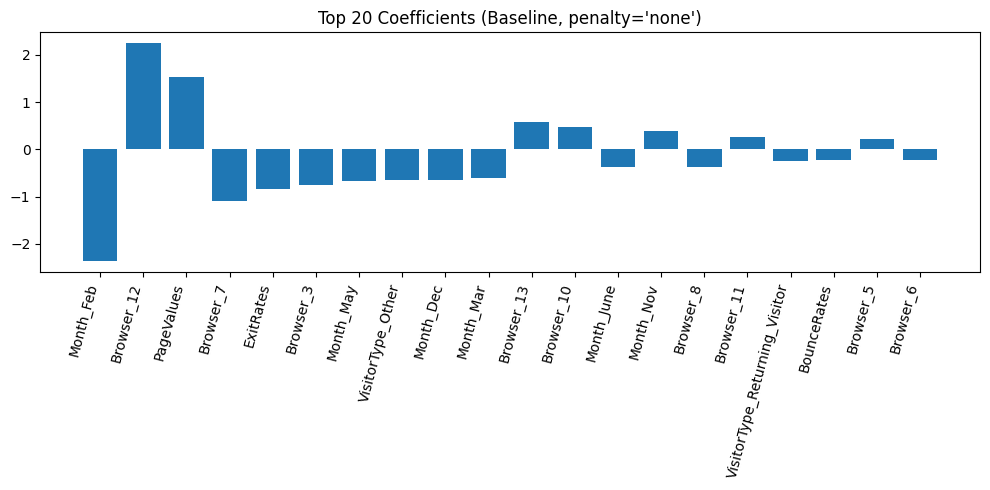

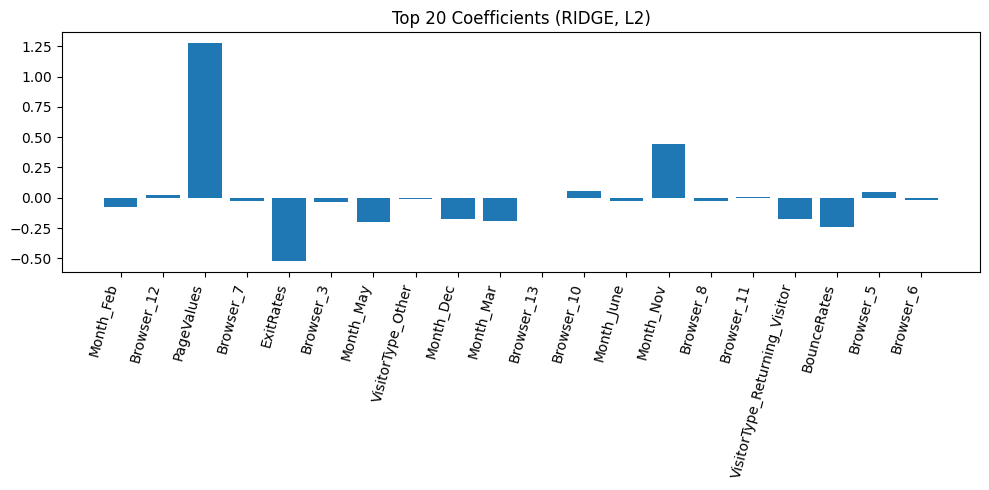

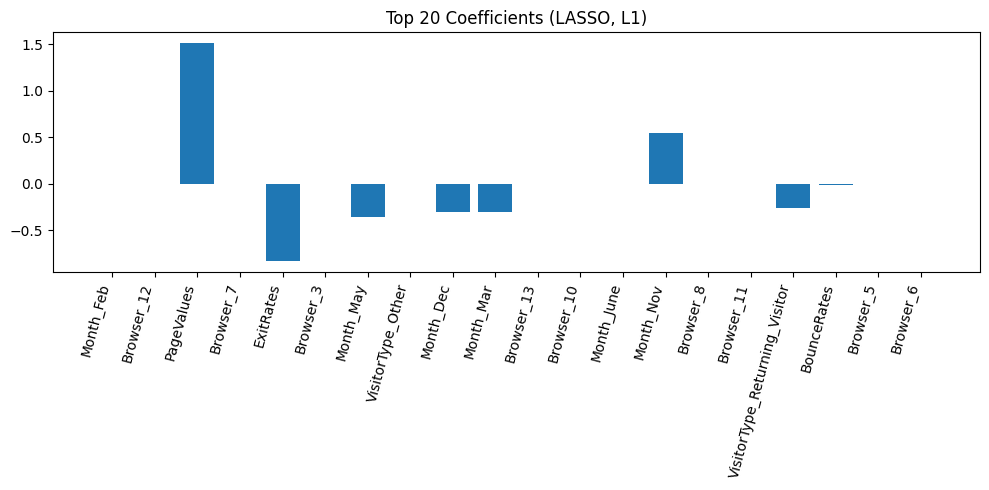

In [7]:
# In[7]: Plot coefficients for baseline, RIDGE (best L2), and LASSO (best L1)
feature_names = X.columns.tolist()
coef_base = baseline_clf.coef_.ravel()
coef_l2 = best_l2_model.coef_.ravel()
coef_l1 = best_l1_model.coef_.ravel()

import numpy as np
order = np.argsort(np.abs(coef_base))[::-1]
topk = 20

plt.figure(figsize=(10, 5))
plt.bar(range(topk), coef_base[order][:topk])
plt.xticks(range(topk), [feature_names[i] for i in order[:topk]], rotation=75, ha='right')
plt.title("Top 20 Coefficients (Baseline, penalty='none')")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(range(topk), coef_l2[order][:topk])
plt.xticks(range(topk), [feature_names[i] for i in order[:topk]], rotation=75, ha='right')
plt.title("Top 20 Coefficients (RIDGE, L2)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(range(topk), coef_l1[order][:topk])
plt.xticks(range(topk), [feature_names[i] for i in order[:topk]], rotation=75, ha='right')
plt.title("Top 20 Coefficients (LASSO, L1)")
plt.tight_layout()
plt.show()

## 7) ROC Curve

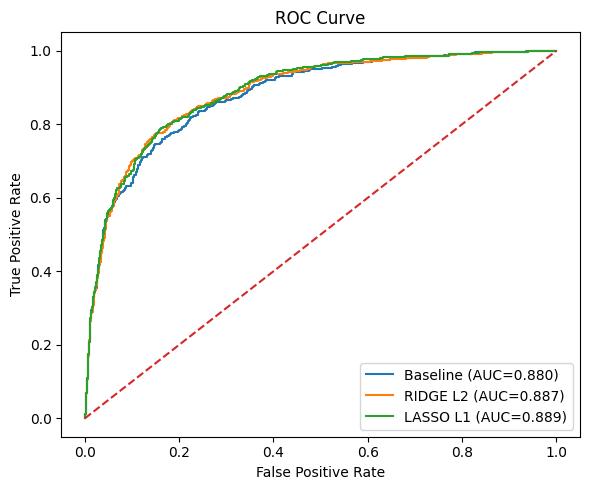

In [8]:
# In[8]: ROC curves for all three models
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_base)
y_proba_l2 = best_l2_model.predict_proba(X_test)[:, 1]
fpr_l2, tpr_l2, _ = roc_curve(y_test, y_proba_l2)
y_proba_l1 = best_l1_model.predict_proba(X_test)[:, 1]
fpr_l1, tpr_l1, _ = roc_curve(y_test, y_proba_l1)

plt.figure(figsize=(6, 5))
plt.plot(fpr_base, tpr_base, label=f"Baseline (AUC={roc_auc_score(y_test, y_proba_base):.3f})")
plt.plot(fpr_l2, tpr_l2, label=f"RIDGE L2 (AUC={roc_auc_score(y_test, y_proba_l2):.3f})")
plt.plot(fpr_l1, tpr_l1, label=f"LASSO L1 (AUC={roc_auc_score(y_test, y_proba_l1):.3f})")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

## 8) Confusion Matrices (default threshold 0.5)

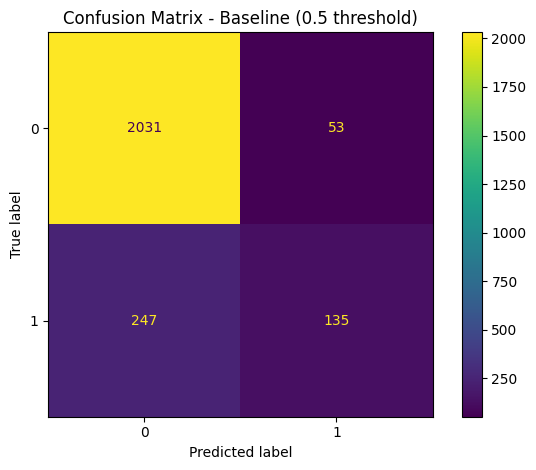

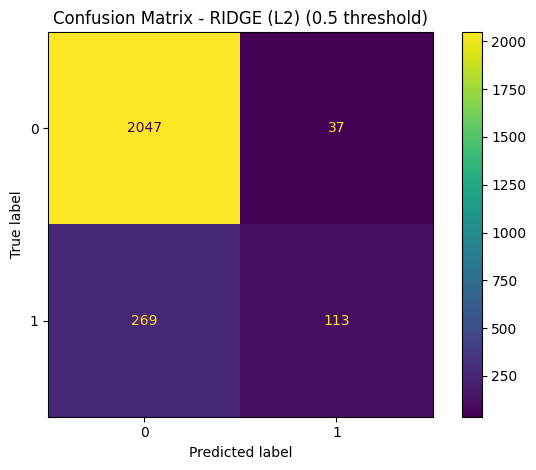

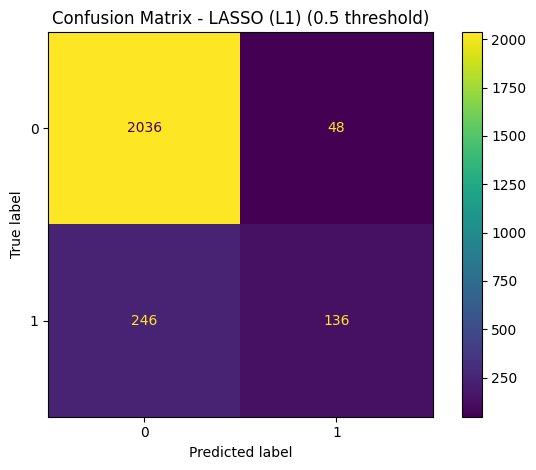

In [9]:
# In[9]: Confusion matrices for all three models
y_pred_l2 = best_l2_model.predict(X_test)
y_pred_l1 = best_l1_model.predict(X_test)

cm_base = confusion_matrix(y_test, y_pred_base)
cm_l2 = confusion_matrix(y_test, y_pred_l2)
cm_l1 = confusion_matrix(y_test, y_pred_l1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_base)
disp.plot()
plt.title("Confusion Matrix - Baseline (0.5 threshold)")
plt.tight_layout()
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_l2)
disp.plot()
plt.title("Confusion Matrix - RIDGE (L2) (0.5 threshold)")
plt.tight_layout()
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_l1)
disp.plot()
plt.title("Confusion Matrix - LASSO (L1) (0.5 threshold)")
plt.tight_layout()
plt.show()

## 9) Metrics Summary & Save

In [10]:
# In[10]: Assemble metrics table and save
rows = []
rows.append({"model": "baseline_penalty_none", **base_metrics})
rows.append({"model": f"ridge_l2_C_{best_C}", **best_l2_metrics})
rows.append({"model": f"lasso_l1_C_{best_l1_C}", **best_l1_metrics})
results_df = pd.DataFrame(rows)

out_csv = "log_reg_results.csv"
results_df.to_csv(out_csv, index=False)
print("Saved metrics to:", out_csv)

# Save best L2 model as well
best_l2_path = "log_reg_l2_best.pkl"
joblib.dump(best_l2_model, best_l2_path)
print(f"Saved best RIDGE model to: {best_l2_path}")

results_df

Saved metrics to: log_reg_results.csv
Saved best RIDGE model to: log_reg_l2_best.pkl


,model,accuracy,precision,recall,f1,roc_auc
0,baseline_penalty_none,0.878345,0.718085,0.353403,0.473684,0.879968
1,ridge_l2_C_0.01,0.875912,0.753333,0.295812,0.424812,0.887043
2,lasso_l1_C_0.1,0.880779,0.739130,0.356021,0.480565,0.889253
